# DL CNN 정리

- toc:true

In [2]:
import torch 
import torchvision
from fastai.vision.all import * 
import time

## CNN 구조


간략하게 CNN의 구조를 설명하자면
- conv layer: 커널층(선형변환처럼 feature를 늘려주는 역할)
- ReLU layer: 비선형을 추가해 표현력을 늘려주는 역할
- pooling layer: max 또는 avg를 통해 데이터를 요약해주는 역할

### conv layer

In [3]:
torch.manual_seed(43052)
_conv = torch.nn.Conv2d(1,1,(2,2)) # 입력1, 출력1, (2,2) window size
# (굳이 (2,2) 이런식으로 안해도 됨 어차피 윈도우 사이즈는 정사각행렬이므로 상수하나만 입력해도 됨됨)

_X = torch.arange(0,25).float().reshape(1,5,5)
_X

tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14.],
         [15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24.]]])

In [4]:
_conv.weight.data = torch.tensor([[[[0.25, 0.25],[0.25,0.25]]]])
_conv.bias.data = torch.tensor([0.0])
_conv.weight.data, _conv.bias.data

(tensor([[[[0.2500, 0.2500],
           [0.2500, 0.2500]]]]), tensor([0.]))

In [5]:
_conv(_X)

tensor([[[ 3.,  4.,  5.,  6.],
         [ 8.,  9., 10., 11.],
         [13., 14., 15., 16.],
         [18., 19., 20., 21.]]], grad_fn=<SqueezeBackward1>)

conv_tensor[1,1] = [[0, 1],[5, 6]]의 평균임을 알 수 있음 (conv.weight가 모두 1/4이어서 그런거임) 
- 해당 값은 (0 + 1 + 5 + 6) / 4 임을 알 수 있음
- 윈도우(커널)는 한 칸씩 움직이면서 weight를 곱하고 bias를 더함
  - 첫 번째 3이라는 값은 [[0, 1],[5, 6]]에 conv을 적용
  - 두 번째 4라는 값은 [[1, 2],[6, 7]]에 conv을 적용

---

### ReLU layer

- 사실 ReLU는 DNN에서와 같이 음수는 0으로 양수는 그대로 되는 함수이다.  
$ReLU(x) = \max(0,x)$

### pooling layer
- pooling layer에는 maxpooling이 있고 avgpooling이 있지만 이번에는 maxpooling을 다룰것임
- maxpooling은 데이터 요약보다는 크기를 줄이는 느낌이 있음

In [6]:
_maxpooling = torch.nn.MaxPool2d((2,2))
_X = torch.arange(0,25).float().reshape(1,5,5)
_X

tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14.],
         [15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24.]]])

In [7]:
_maxpooling(_X) 

tensor([[[ 6.,  8.],
         [16., 18.]]])

- maxpooling_tensor[1,1] = [[0, 1],[5, 6]] 중 가장 큰 값을 이므로 5이다.
- pooling은 convlayer와 달리 pooling box가 겹치지 않게 움직임
  - 이러한 특성으로 인해 5번째 열과 행에 있는 값들은 pooling box에 들어가지 못해 버려지게 된다

## CNN 구현

In [8]:
path = untar_data(URLs.MNIST)

### path 사용법 + 데이터 준비
- 
``` python
(path/'원하는 경로').ls()
```
위 코드를 사용하면 폴더 안에 있는 데이터들의 이름을 출력
- 
``` python
torchvision.io.read_image()
```
해당 함수에 데이터 이름(이미지 이름)을 넣어주면 이미지를 tensor형태로 출력

In [9]:
# train data
x0 = torch.stack([torchvision.io.read_image(str(fnames)) for fnames in (path/'training/0').ls()])
x1 = torch.stack([torchvision.io.read_image(str(fnames)) for fnames in (path/'training/1').ls()])
x_tr = torch.concat([x0, x1])/255

y_tr = torch.tensor([0.0]*len(x0) + [1.0]*len(x1)).reshape(-1,1)

In [10]:
# train data
x0 = torch.stack([torchvision.io.read_image(str(fnames)) for fnames in (path/'testing/0').ls()])
x1 = torch.stack([torchvision.io.read_image(str(fnames)) for fnames in (path/'testing/1').ls()])
x_test = torch.concat([x0, x1])/255

y_test = torch.tensor([0.0]*len(x0) + [1.0]*len(x1)).reshape(-1,1)

In [11]:
x_tr.shape, y_tr.shape, x_test.shape, y_test.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([2115, 1]))

### cnn에 사용되는 layer 알아보기

In [12]:
# conv
c1 = torch.nn.Conv2d(1, 16 , 5) # 만약 color image였다면 입력 채널의 수를 3으로 지정해야 함
x_tr.shape ,c1(x_tr).shape

(torch.Size([12665, 1, 28, 28]), torch.Size([12665, 16, 24, 24]))

- size계산 공식: 윈도우(커널)사이즈가 n이면 $size = height(width) - ( n - 1)$

In [13]:
# ReLU
a1 = torch.nn.ReLU()

In [14]:
# maxpooling
m1 = torch.nn.MaxPool2d(2)
print(m1(a1(c1(x_tr))).shape)

torch.Size([12665, 16, 12, 12])


- 행과 열이 2의 배수이므로 maxpool이 2일때는 버려지는 행과 열은 없다.

In [15]:
# flatten(이미지를 한줄로 펼치는 것)
f1 = torch.nn.Flatten()
print(f1(a1(m1(c1(x_tr)))).shape) #16 * 12 * 12 = 2304

torch.Size([12665, 2304])


In [16]:
# sigmoid에 올리기 위해서는 2304 디멘젼을 1로 만들어야함
l1=torch.nn.Linear(in_features=2304,out_features=1) 

In [17]:
# sigmoid (값이 0에서 1사이의 값, 즉 확률로 출력되도록)
a2 = torch.nn.Sigmoid()
print(a2(f1(a1(m1(c1(x_tr))))).shape)

torch.Size([12665, 2304])


In [18]:
print('이미지 사이즈:                     ', x_tr.shape)
print('conv:                              ',c1(x_tr).shape)
print('(ReLU) -> maxpooling:              ',m1(a1(c1(x_tr))).shape)
print('이미지 펼치기:                     ',f1(a1(m1(c1(x_tr)))).shape)
print('이미지를 하나의 스칼라로 선형변환: ',l1(f1(a1(m1(c1(x_tr))))).shape)
print('시그모이드:                        ',a2(l1(f1(a1(m1(c1(x_tr)))))).shape)

이미지 사이즈:                      torch.Size([12665, 1, 28, 28])
conv:                               torch.Size([12665, 16, 24, 24])
(ReLU) -> maxpooling:               torch.Size([12665, 16, 12, 12])
이미지 펼치기:                      torch.Size([12665, 2304])
이미지를 하나의 스칼라로 선형변환:  torch.Size([12665, 1])
시그모이드:                         torch.Size([12665, 1])


### networks 설계 

- 원래라면 아래와 같은 코드를 사용하여 network를 학습시키겠지만 CNN과 같이 파라미터가 많은 network는 CPU로 연산시 학습할때 시간이 오래걸림
```python
loss_fn=torch.nn.BCELoss()
optimizr= torch.optim.Adam(net.parameters())
t1= time.time()
for epoc in range(100): 
    ## 1 
    yhat=net(x_tr)
    ## 2 
    loss=loss_fn(yhat,y_tr) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1
```
$\to$ overview때 배운 fastai에 있는 데이터로더를 사용하면 GPU를 사용해 연산을 할 수 있다.


In [19]:
# 데이터 로더에 들어갈 데이터세트 준비
ds_tr = torch.utils.data.TensorDataset(x_tr, y_tr)
ds_test = torch.utils.data.TensorDataset(x_test, y_test)

- 데이터 로더는 배치크기를 지정해줘야 함

In [20]:
len(x_tr), len(x_test)

(12665, 2115)

- 데이터가 각각 12665, 2115개씩 들어가 있으므로 한번 업데이트할 때 총 데이터의 1 /10을 쓰도록 아래와 같이 배치 크기를 줌
  - stochastic gradient descent(구용어: mini-batch gradient descent)

In [21]:
# 데이터 로더
dl_tr = torch.utils.data.DataLoader(ds_tr,batch_size=1266) 
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=2115) 

In [22]:
dls = DataLoaders(dl_tr,dl_test)

In [23]:
net = torch.nn.Sequential(
    # conv layer 
    c1, 
    # ReLU
    a1, 
    # maxpool
    m1, 
    # flatten
    f1, 
    # linear transform (n -> 1)
    l1,
    # Sigmoid
    a2
)

loss_fn=torch.nn.BCELoss()

In [24]:
lrnr = Learner(dls,net,loss_fn) # fastai의 Learner는 오미타이저의 기본값이 adam이므로 따로 지정해주지 않아도 됨

In [25]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,0.979273,0.639250,00:05
1,0.703008,0.402466,00:00
2,0.547401,0.256881,00:00
3,0.434025,0.142217,00:00
4,0.340996,0.079636,00:00
5,0.267902,0.048050,00:00
6,0.211895,0.031742,00:00
7,0.169176,0.022921,00:00
8,0.136331,0.017658,00:00
9,0.110770,0.014233,00:00


- Learner 오브젝트에 들어간 net은 gpu상에 있도록 되어있음
> ``` python 
  net[0].weight
  ```
  위 코드를 출력하면 weight tensor가 출력되는데 가장 밑을 확인하면 device = 'cuda:0'라는 것이 있음. 이는 해당 tensor가 gpu상에 위치해있는 것을 의미한다. 
   
   `+` tensor 연산을 할 때에는 모든 tensor가 같은 곳에 위치해있어야 한다.

Text(0.5, 1.0, 'Training Set')

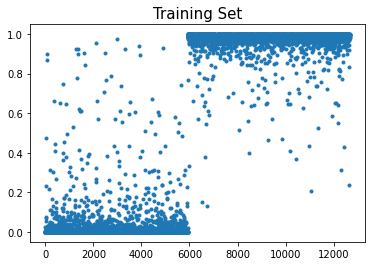

In [26]:
net = net.to('cpu')
plt.plot(net(x_tr).data,'.')
plt.title("Training Set",size=15)

Text(0.5, 1.0, 'Testing Set')

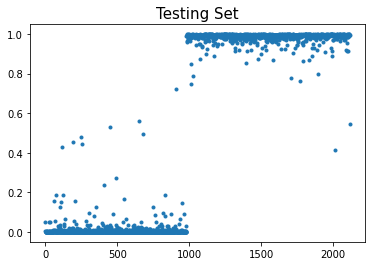

In [27]:
plt.plot(net(x_test).data,'.')
plt.title("Testing Set",size=15)

## Loss function

### BCEWithLogitsLoss
- BCEWithLogitsLoss = Sigmoid + BCELoss
- 손실함수로 이를 사용하면 network 마지막에 시그모이드 함수를 추가하지 않아도 됨
- 이를 사용하면 수치적으로 더 안정이 된다는 장점이 있음

## k개의 클래스를 분류하는 모델

>다중(k개) 클래스를 분류
- LossFunction: CrossEntrophyLoss  
- ActivationFunction: SoftmaxFunction
- 마지막 출력층: torch.nn.Linear(n, k)



### SoftmaxFunction
- 소프트맥스 함수가 계산하는 과정은 아래와 같음
(3개를 분류할 경우) $softmax=\frac{e^{a 또는 b 또는 c}}{e^{a} + e^{b} + e^{c}}$

### CrossEntrophyLoss
- k개의 클래스를 분류하는 모델의 Loss 계산 방법

``` python
sftmax(_netout) # -> 0 ~ 1 사이의 값 k개 출력

torch.log(sftmax(_netout)) # -> 0 ~ 1사이의 값을 로그에 넣게 되면 -∞ ~ 0사이의 값 k개 출력

- torch.log(sftmax(_netout)) * _y_onehot 
# 만약 값이 log(sftmax(_netout)) = [-2.2395, -2.2395, -0.2395] 이렇게 나오고 
#y_onehot이 [1, 0, 0]이라면 해당 코드의 결과, 즉 loss는 2.2395이 된다. 

```
- 만약 모델이 첫 번째 값이 확실하게 정답이라고 생각한다면 로그의 결과값은 0이 된다 -> 해당 값이 정답일경우 0 * 1 = 0이므로 loss는 0이 된다

- 최종적으로는 위 코드를 통해 얻은 Loss를 평균을 내어 출력한다.

`+` 위의 설명은 정답이 원-핫 인코딩 형식으로 되어있을 때의 Loss계산 방법임  
`+` 정답이 vector + 정수형으로 되어 있을 때의 Loss계산 방법은 잘 모르겠음

### 정답(y)의 형태
- type 1) int형을 사용하는 방법 (vector)

- type 2) float형을 사용하는 방법 (one-hot encoded vector)

- 만약 사슴, 강아지, 고양이를 분류하는 모델이라면
  - type 1)의 경우 <사슴: 0, 강아지: 1, 고양이: 2> (단, 데이터 형태는는 int(정수))
  - type 2)의 경우 <사슴: [1, 0, 0],
강아지: [0, 1, 0], 고양이: [0, 0, 1] > (단, 데이터의 형태는 float(실수))

#### vector(int)

In [29]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])

In [30]:
torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)

tensor([0, 0, 0,  ..., 1, 1, 1])

#### one-hot encoded vector(float)

In [31]:
yy = torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)
torch.nn.functional.one_hot(yy).float()

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])

### 다중 클래스 분류 모델

In [32]:
# train
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

In [33]:
# test
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0,X1,X2])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

In [34]:
len(X) # 18623

18623

In [35]:
ds1 = torch.utils.data.TensorDataset(X,y) 
ds2 = torch.utils.data.TensorDataset(XX,yy) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1862) # 에폭당 11번= 1862 꽉 채워서 10번하고 3개정도 남은 걸로 한 번
dl2 = torch.utils.data.DataLoader(ds2,batch_size=3147) # test는 전부다 넣어서
dls = DataLoaders(dl1,dl2) 

In [36]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,3) # 0,1,2 3개를 구분하는 문제이므로 out_features=3 
)

loss_fn = torch.nn.CrossEntropyLoss() # 여기에는 softmax함수가 내장되어 있음 
#-> net마지막에 softmax를 넣으면 안됨
# BCEWithLogitsLoss 느낌(시그모이드 + BCE)

In [37]:
lrnr = Learner(dls,net,loss_fn) # 옵티마이저는 아답이 디폴트 값이어서 굳이 안넣어도 됨

In [38]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,time
0,1.797101,1.103916,00:00
1,1.267011,0.823797,00:00
2,1.055513,0.667210,00:00
3,0.910746,0.435414,00:00
4,0.762887,0.284001,00:00
5,0.625515,0.199502,00:00
6,0.515352,0.152906,00:00
7,0.429145,0.123678,00:00
8,0.359694,0.105466,00:00
9,0.303888,0.092883,00:00


In [39]:
lrnr.model.to("cpu")

pd.DataFrame(lrnr.model(XX)).assign(y=yy) 

,0,1,2,y
0,0.981043,-9.135092,-1.149270,0
1,-0.292905,-4.281692,-0.924575,0
2,4.085316,-9.199694,-3.482234,0
3,2.484926,-9.336347,-3.127304,0
4,3.310040,-12.257785,-2.177761,0
...,...,...,...,...
3142,-1.138366,-5.435792,0.370670,2
3143,-4.458741,-4.281343,2.052410,2
3144,-2.836508,-3.204013,0.012610,2
3145,-1.704158,-10.621873,2.024313,2


In [40]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==0')

,0,1,2,y
0,0.981043,-9.135092,-1.149270,0
1,-0.292905,-4.281692,-0.924575,0
2,4.085316,-9.199694,-3.482234,0
3,2.484926,-9.336347,-3.127304,0
4,3.310040,-12.257785,-2.177761,0
...,...,...,...,...
975,0.432969,-5.653580,-1.944451,0
976,2.685695,-10.254354,-2.466680,0
977,2.474842,-9.650204,-2.452746,0
978,1.268743,-6.928779,-1.419695,0


- 0으로 분류한 것들은 첫번째 열(0)의 값이 가장 큼 

### 소프트맥스와 시그모이드

- 이진 분류시에는 소프트맥스와 시그모이드 모두 activation function으로 사용할 수 있지만 소프트맥스를 사용하면 출력층이 2개가 되므로 파라미터 낭비가 심해진다.
- 이진 분류시에는 시그모이드를 사용하는 것이 적합함.
- 소프트맥스는 3개 이상을 분류해야 할 경우에 사용하면 됨

### 메트릭이용
- fastai에서 지원
- fastai를 사용해 학습(lrnr.fit())을 할때 loss_value만 나오는 것이 아니라 error_rate과 정확도가 나오게 할 수 있는 옵션
- y의 형태를 주의해서 사용해야 함
  - 앞서 말한 것처럼 두 가지 타입이 있음
    - vector + int
    - one-hot encoded vector + float

type 1) y의 형태가 vector + int일 때
- metrics = accuracy를 사용해야 함

In [48]:
# train
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255

In [49]:
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
y.to(torch.int64).reshape(-1)

tensor([0, 0, 0,  ..., 1, 1, 1])

In [50]:
# test
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255

In [51]:
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
yy.to(torch.int64).reshape(-1)

tensor([0, 0, 0,  ..., 1, 1, 1])

In [53]:
ds1 = torch.utils.data.TensorDataset(X,y.to(torch.int64).reshape(-1))
ds2 = torch.utils.data.TensorDataset(XX,yy.to(torch.int64).reshape(-1))

dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

dls = DataLoaders(dl1,dl2) 

In [59]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2)
)
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

In [60]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.128365,0.601474,0.463357,0.536643,00:00
1,0.684630,0.304262,0.975414,0.024586,00:00
2,0.503124,0.144147,0.989598,0.010402,00:00
3,0.373899,0.068306,0.996217,0.003783,00:00
4,0.281332,0.040790,0.996217,0.003783,00:00
5,0.215743,0.026980,0.996690,0.003310,00:00
6,0.168349,0.019467,0.996690,0.003310,00:00
7,0.133313,0.014856,0.998109,0.001891,00:00
8,0.106776,0.011745,0.998109,0.001891,00:00
9,0.086275,0.009553,0.999054,0.000946,00:00


type 2) y의 형태가 one-hot encoded vector + float일 때
- metrics = accuracy_multi를 사용해야 함
- error_rate는 사용못함

In [ ]:
y_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], y)))
yy_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], yy)))

In [61]:
y_onehot = torch.nn.functional.one_hot(y.reshape(-1).to(torch.int64)).to(torch.float32)
yy_onehot = torch.nn.functional.one_hot(yy.reshape(-1).to(torch.int64)).to(torch.float32)

- torch.nn.functional.one_hot() 함수 조건
  - 기본적으로 크기가 n인 벡터가 들어오길 기대 
  - 정수가 들어오는 것을 기대
- 하지만 원-핫 인코딩을 사용할 때에는 실수형으로 저장 되어야 하므로 마지막에 실수형으로 바꿔줘야 함

In [62]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot)
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

In [63]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy_multi])

In [64]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.213650,0.647844,0.463357,00:00
1,0.744869,0.384000,0.933570,00:00
2,0.571879,0.187119,0.986525,00:00
3,0.432096,0.090841,0.994563,00:00
4,0.326718,0.048868,0.995508,00:00
5,0.250235,0.028477,0.996217,00:00
6,0.194605,0.018616,0.996454,00:00
7,0.153338,0.013278,0.996927,00:00
8,0.122056,0.010130,0.997872,00:00
9,0.097957,0.008112,0.998109,00:00
